<div style="text-align:right;">Justine Charrel - Master 1 Internship</div>

This script calculate the differences between the radiosoundings of MOSAiC and them of ERA5.

It will be used to realize unsupervised machine learning (self-organizing maps) on relative humidity. 

### IMPORT

In [229]:
from netCDF4 import Dataset as ncfile
import numpy as np
from netCDF4 import num2date
import matplotlib.dates as dates
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import cmath

### READ DATA

In [31]:
ppidir = '/lustre/storeB/users/justinec/master_internship/data/ERA5_MOSAiC/'
data_link  = ppidir + 'concatenated_ERA5_MOSAiC.nc'

data = ncfile(data_link,'r')    #dataset of radiosoundings of MOSAiC and ERA5

In [32]:
pres = data.variables['pres'][:]
lat = data.variables['lat_mosaic'][:] 
lon = data.variables['lon_mosaic'][:]
time = data.variables['time_mosaic'][:]
era5_temp = data.variables['temp_era5'][:]
era5_rh = data.variables['rh_era5'][:]
era5_wdir = data.variables['wdir_era5'][:]
era5_wspeed = data.variables['wspeed_era5'][:]
mosaic_temp = data.variables['temp_mosaic'][:]
mosaic_rh = data.variables['rh_mosaic'][:]
mosaic_wdir = data.variables['wdir_mosaic'][:]
mosaic_wspeed = data.variables['wspeed_mosaic'][:]

In [33]:
def convert_time(dataset) :
    dataset_time = dataset.variables['time_mosaic']
    t_unit = dataset_time.units
    t_cal = dataset_time.calendar
    dataset_nctime=[]; 
    dataset_nctime.append(num2date(dataset_time,units = t_unit,calendar = t_cal, only_use_python_datetimes=True, only_use_cftime_datetimes=False)) #datetime of type 2019-10-01 00:00:00
    #dates.date2num --> convert datetime objects to Matplotlib dates (better for compare ERA5 and MOSAiC times and for figures)
    #np.squeeze --> pass Matplotlib dates in column instead of in line
    dataset_nctimenum = np.squeeze(dates.date2num(dataset_nctime))
    return dataset_nctime,dataset_nctimenum,t_unit

In [34]:
nctime, nctimenum, t_unit = convert_time(data)

### CALCULATE THE BIASES BETWEEN ERA5 AND MOSAiC

In [35]:
mosaic_rh[559][11] = np.nan #outlier value 9.969209968386869e+36 replaced by NaN value

In [36]:
mosaic_temp = mosaic_temp.filled() #replace masked values by NaN values
mosaic_rh = mosaic_rh.filled()
mosaic_wdir = mosaic_wdir.filled()
mosaic_wspeed = mosaic_wspeed.filled()

In [37]:
temp_bias = era5_temp-mosaic_temp
rh_bias = era5_rh-mosaic_rh
wspeed_bias = era5_wspeed-mosaic_wspeed

In [38]:
# need to use direction errors
wdir_bias = era5_wdir-mosaic_wdir
for i in range(len(wdir_bias)) :
    for n in range(len(wdir_bias[i])) :
        if wdir_bias[i][n] > 180 :
            wdir_bias[i][n] = wdir_bias[i][n]-360
        if wdir_bias[i][n] < -180 :
            wdir_bias[i][n] = wdir_bias[i][n]+360

### DISTRIBUTION OF THE BIASES

In [39]:
def varlevel(var) :
    var_1000 = []
    var_900 = []
    var_600 = []
    var_300 = []
    for i in range(len(var)) :
        var_1000.append(var[i][28])
        var_900.append(var[i][25])
        var_600.append(var[i][12])
        var_300.append(var[i][0])
    return(var_1000,var_900,var_600,var_300)

In [40]:
temp_bias_1000, temp_bias_900, temp_bias_600, temp_bias_300 = varlevel(temp_bias)
rh_bias_1000, rh_bias_900, rh_bias_600, rh_bias_300 = varlevel(rh_bias)
wdir_bias_1000, wdir_bias_900, wdir_bias_600, wdir_bias_300 = varlevel(wdir_bias)
wspeed_bias_1000, wspeed_bias_900, wspeed_bias_600, wspeed_bias_300 = varlevel(wspeed_bias)

In [77]:
def plotdistribution() :
    parameters = {'axes.labelsize':20, 'axes.titlesize':20, 'legend.fontsize':16, 'xtick.labelsize':20, 'ytick.labelsize':20, 
                      'legend.title_fontsize':20, 'figure.titlesize':25}
    plt.rcParams.update(parameters)
    fig, axs = plt.subplots(2,2,figsize=(30,15))
    sns.histplot(temp_bias_300, binrange=(-10,10), binwidth=0.1, label='300 hPa', ax=axs[0,0], alpha=0.4, color='purple')
    sns.histplot(temp_bias_600, binrange=(-10,10), binwidth=0.1, label='600 hPa', ax=axs[0,0], alpha=0.4, color='yellow')
    sns.histplot(temp_bias_900, binrange=(-10,10), binwidth=0.1, label='900 hPa', ax=axs[0,0], alpha=0.4, color='green')
    sns.histplot(temp_bias_1000, binrange=(-10,10), binwidth=0.1, label='1000 hPa', ax=axs[0,0], alpha=0.4, color='red')
    axs[0,0].set(ylabel='Number of occurences', xlabel='T difference [K]')
    #axs[0,0].set_xlim(-10,10)
    axs[0,0].legend()

    sns.histplot(rh_bias_300, binrange=(-50,100), binwidth=1, label='300 hPa', ax=axs[0,1], alpha=0.4, color='purple')
    sns.histplot(rh_bias_600, binrange=(-50,100), binwidth=1, label='600 hPa', ax=axs[0,1], alpha=0.4, color='yellow')
    sns.histplot(rh_bias_900, binrange=(-50,100), binwidth=1, label='900 hPa', ax=axs[0,1], alpha=0.4, color='green')
    sns.histplot(rh_bias_1000, binrange=(-50,100), binwidth=1, label='1000 hPa',ax=axs[0,1], alpha=0.4, color='red')
    axs[0,1].set(ylabel='', xlabel='RH difference [%]')
    axs[0,1].legend()

    sns.histplot(wdir_bias_300, binrange=(-150,150), binwidth=2, label='300 hPa', ax=axs[1,0], alpha=0.4, color='purple')
    sns.histplot(wdir_bias_600, binrange=(-150,150), binwidth=2, label='600 hPa', ax=axs[1,0], alpha=0.4, color='yellow')
    sns.histplot(wdir_bias_900, binrange=(-150,150), binwidth=2, label='900 hPa', ax=axs[1,0], alpha=0.4, color='green')
    sns.histplot(wdir_bias_1000, binrange=(-150,150), binwidth=2, label='1000 hPa', ax=axs[1,0], alpha=0.4, color='red')
    axs[1,0].set(ylabel='Number of occurences', xlabel='Wind direction difference [degree]')
    axs[1,0].legend()

    sns.histplot(wspeed_bias_300, binrange=(-15,15), binwidth=0.2, label='300 hPa', ax=axs[1,1], alpha=0.4, color='purple')
    sns.histplot(wspeed_bias_600, binrange=(-15,15), binwidth=0.2, label='600 hPa', ax=axs[1,1], alpha=0.4, color='yellow')
    sns.histplot(wspeed_bias_900, binrange=(-15,15), binwidth=0.2, label='900 hPa', ax=axs[1,1], alpha=0.4, color='green')
    sns.histplot(wspeed_bias_1000, binrange=(-15,15), binwidth=0.2, label='1000 hPa', ax=axs[1,1], alpha=0.4, color='red')
    axs[1,1].set(ylabel='', xlabel=r'Wind speed difference [$m.s^{-1}$]')
    axs[1,1].legend()

    fig.suptitle('Distribution of differences betweeen ERA5 and MOSAiC')
    fig.tight_layout()
    fig.subplots_adjust(top=0.93)
    path_fig = '/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_biases/'
    plt.savefig(path_fig+'fig_biases_distribution.png')

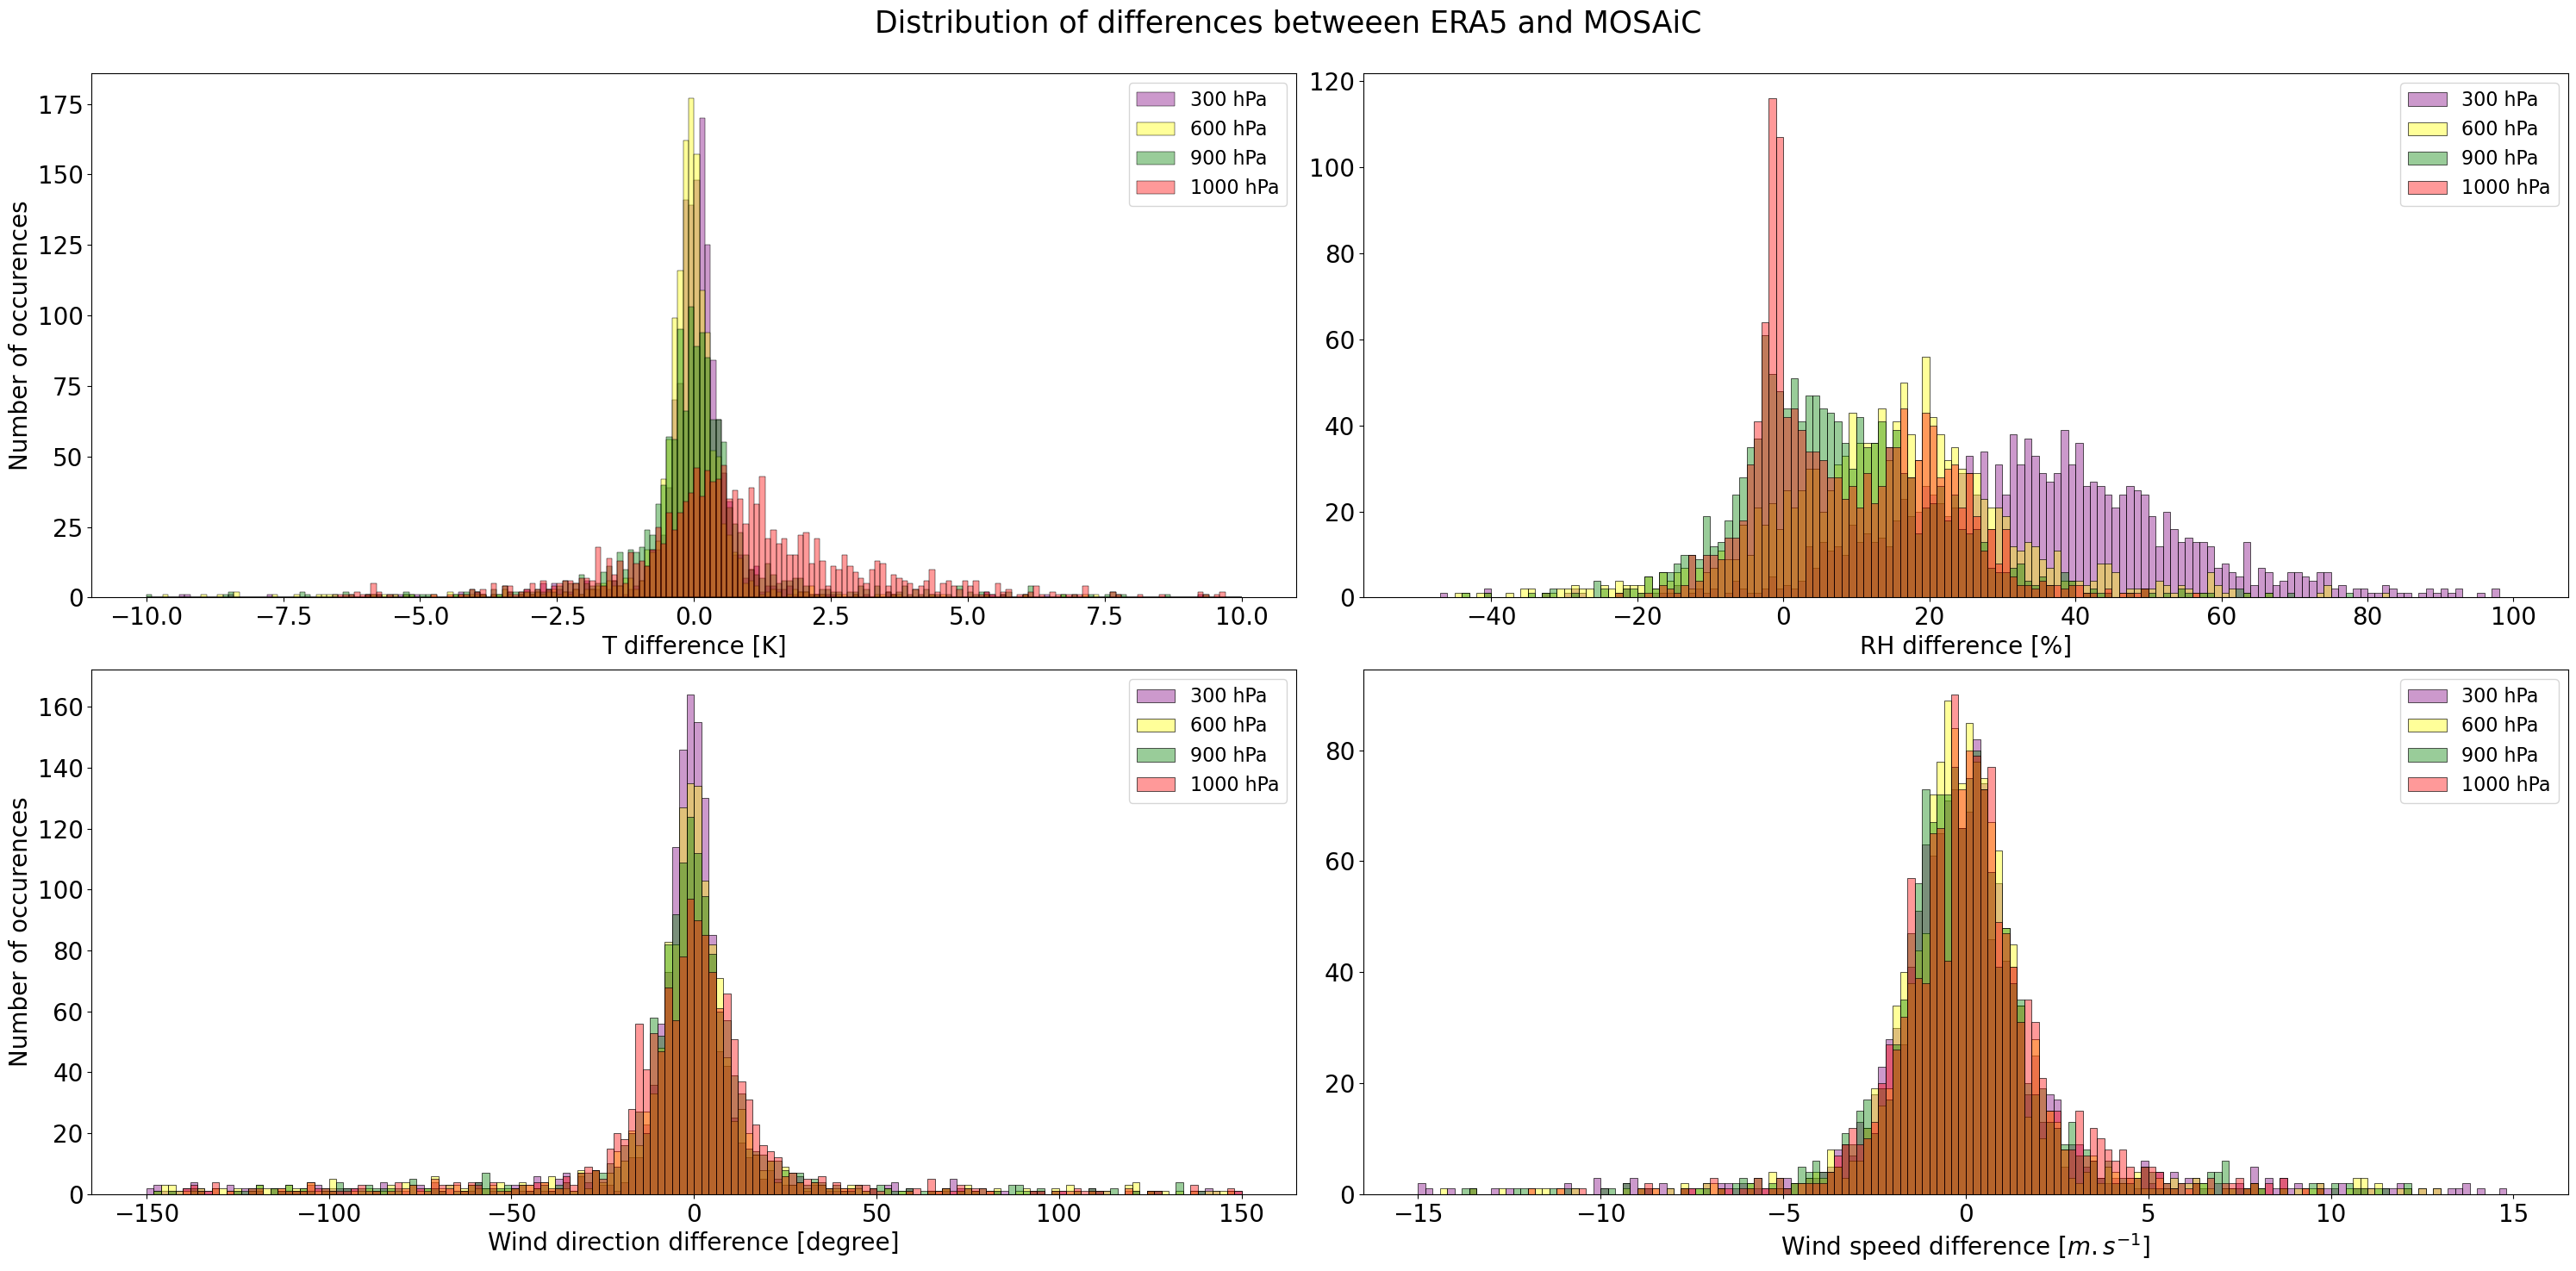

In [78]:
plotdistribution()

### CALCULATE MEAN AND STANDARD DEVIATION OF EVERY PRESSURE LEVEL FOR ALL RADIOSONDES

In [82]:
def meanstd(var) :
    mean = np.nanmean(var, axis=0)
    std  = np.nanstd(temp_bias, axis=0)
    return(mean,std)

In [214]:
mean_temp_bias, std_temp_bias = meanstd(temp_bias)
mean_rh_bias, std_rh_bias = meanstd(rh_bias)
mean_wdir_bias, std_wdir_bias = meanstd(wdir_bias)
mean_wspeed_bias, std_wspeed_bias = meanstd(wspeed_bias)

In [265]:
def corr_coef(mosaic,era5) :
    mosaic_level = [] ; era5_level = [] ; r=[]
    for n in range(len(mosaic[0])) :
        for i in range(len(mosaic)) :
            mosaic_level.append(mosaic[i][n])
            era5_level.append(era5[i][n])
        r.append(np.ma.corrcoef(np.ma.masked_invalid(mosaic_level), np.ma.masked_invalid(era5_level))[0,1])
    return r

In [266]:
r_temp=corr_coef(mosaic_temp,era5_temp)
r_rh=corr_coef(mosaic_rh,era5_rh)
r_wspeed=corr_coef(mosaic_wspeed,era5_wspeed)

In [269]:
def circular_correlation_coefficient(variable1, variable2):
        #
        var1_rad = variable1 * np.pi / 180
        var2_rad = variable2 * np.pi / 180
        #
        var1_com = np.full(np.shape(variable1), np.nan, dtype = complex)
        var2_com = np.full(np.shape(variable2), np.nan, dtype = complex)
        for i in range(0, len(variable1)):
                var1_com[i] = cmath.rect(1, var1_rad[i])
                var2_com[i] = cmath.rect(1, var2_rad[i])
        #
        var1_com_mean = np.mean(var1_com)
        var2_com_mean = np.mean(var2_com)
        #
        var1_rad_mean = cmath.phase(var1_com_mean)
        if var1_rad_mean < 0:
                var1_rad_mean = var1_rad_mean + 2 * np.pi
        #
        var2_rad_mean = cmath.phase(var2_com_mean)
        if var2_rad_mean < 0:
                var2_rad_mean = var2_rad_mean + 2 * np.pi
        #
        diff_var1 = var1_rad - var1_rad_mean
        diff_var2 = var2_rad - var2_rad_mean
        #
        Rcc = np.sum(np.sin(diff_var1) * np.sin(diff_var2)) / np.sqrt(np.sum(np.sin(diff_var1) ** 2) * np.sum(np.sin(diff_var2) ** 2))
        #
        return Rcc

In [267]:
mosaic_level = [] ; era5_level = [] ; r_wdir=[]
for n in range(len(pres)):
    for i in range(len(mosaic_wdir)) :
        mosaic_level.append(mosaic_wdir[i][n])
        era5_level.append(era5_wdir[i][n])
    a=np.array(mosaic_level)
    b=np.array(era5_level)
    r_wdir.append(circular_correlation_coefficient(a, b))

In [268]:
r

[0.6748239096374324,
 0.6388039596483397,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

### PLOT

In [270]:
def plotbiases() :
    
    import matplotlib.gridspec as gridspec
    from matplotlib import pyplot as plt

    parameters = {'axes.labelsize':20, 'axes.titlesize':20, 'legend.fontsize':16, 'xtick.labelsize':20, 'ytick.labelsize':20, 
                  'legend.title_fontsize':20, 'figure.titlesize':25}
    plt.rcParams.update(parameters)

    fig, axs = plt.subplots(1,4,figsize=(30,15))
    for i in range(len(temp_bias)) :
        axs[0].plot(temp_bias[i], pres, 'gray', alpha=0.3)
    axs[0].fill_betweenx(pres, mean_temp_bias-std_temp_bias, mean_temp_bias+std_temp_bias, label='standard deviation', alpha = 0.2, edgecolor='b', facecolor='b', zorder=2)
    axs[0].plot(mean_temp_bias, pres, 'k', label = 'mean')
    axs0 = axs[0].twiny()
    axs0.plot(r_temp, pres, 'r', label = 'correlation coefficient')
    axs0.set_xlim(0.65,1)
    axs[0].invert_yaxis()
    axs[0].set_xlabel ('T [K]')
    axs[0].set_ylabel ('Pressure [hPa]')
    
    for i in range(len(rh_bias)) :
        axs[1].plot(rh_bias[i], pres, 'gray', alpha=0.3)
    axs[1].fill_betweenx(pres, mean_rh_bias-std_rh_bias, mean_rh_bias+std_rh_bias, alpha = 0.2, edgecolor='b', facecolor='b', zorder=2)
    axs[1].plot(mean_rh_bias, pres, 'k')
    axs1 = axs[1].twiny()
    axs1.plot(r_rh, pres, 'r')
    axs1.set_xlim(0.65,1)
    axs[1].invert_yaxis()
    axs[1].set_xlabel ('RH [%]')

    for i in range(len(wdir_bias)) :
        axs[2].plot(wdir_bias[i], pres, 'gray', alpha=0.3)
    axs[2].fill_betweenx(pres, mean_wdir_bias-std_wdir_bias, mean_wdir_bias+std_wdir_bias, alpha = 0.2, edgecolor='b', facecolor='b', zorder=2)
    axs[2].plot(mean_wdir_bias, pres, 'k')
    #axs2 = axs[2].twiny()
    #axs2.plot(r_wdir, pres, 'r')
    #axs2.set_xlim(0.65,1)
    axs[2].invert_yaxis()
    axs[2].set_xlabel ('Wind direction [degree]')

    for i in range(len(wspeed_bias)) :
        axs[3].plot(wspeed_bias[i], pres, 'gray', alpha=0.3)
    axs[3].fill_betweenx(pres, mean_wspeed_bias-std_wspeed_bias, mean_wspeed_bias+std_wspeed_bias, alpha = 0.2, edgecolor='b', facecolor='b', zorder=2)
    axs[3].plot(mean_wspeed_bias, pres, 'k')
    axs3 = axs[3].twiny()
    axs3.plot(r_wspeed, pres, 'r')
    axs3.set_xlim(0.65,1)
    axs[3].invert_yaxis()
    axs[3].set_xlabel (r'Wind speed [$m.s^{-1}$]')

    #date = day + '/' + month + '/' + year + ' ' + hour + ':' + date_task[10:12] + ':' + date_task[12:14]
    #fig.suptitle(date, size=16)
    fig.suptitle('Difference between ERA5 and MOSAiC from 10/2019 to 10/2020')
    fig.legend()
    fig.tight_layout()
    fig.subplots_adjust(top=0.87)
    path_fig = '/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_biases/'
    #plt.savefig(path_fig+'fig_biases_'+date_task+'.png')
    plt.savefig(path_fig+'fig_biases_.png')

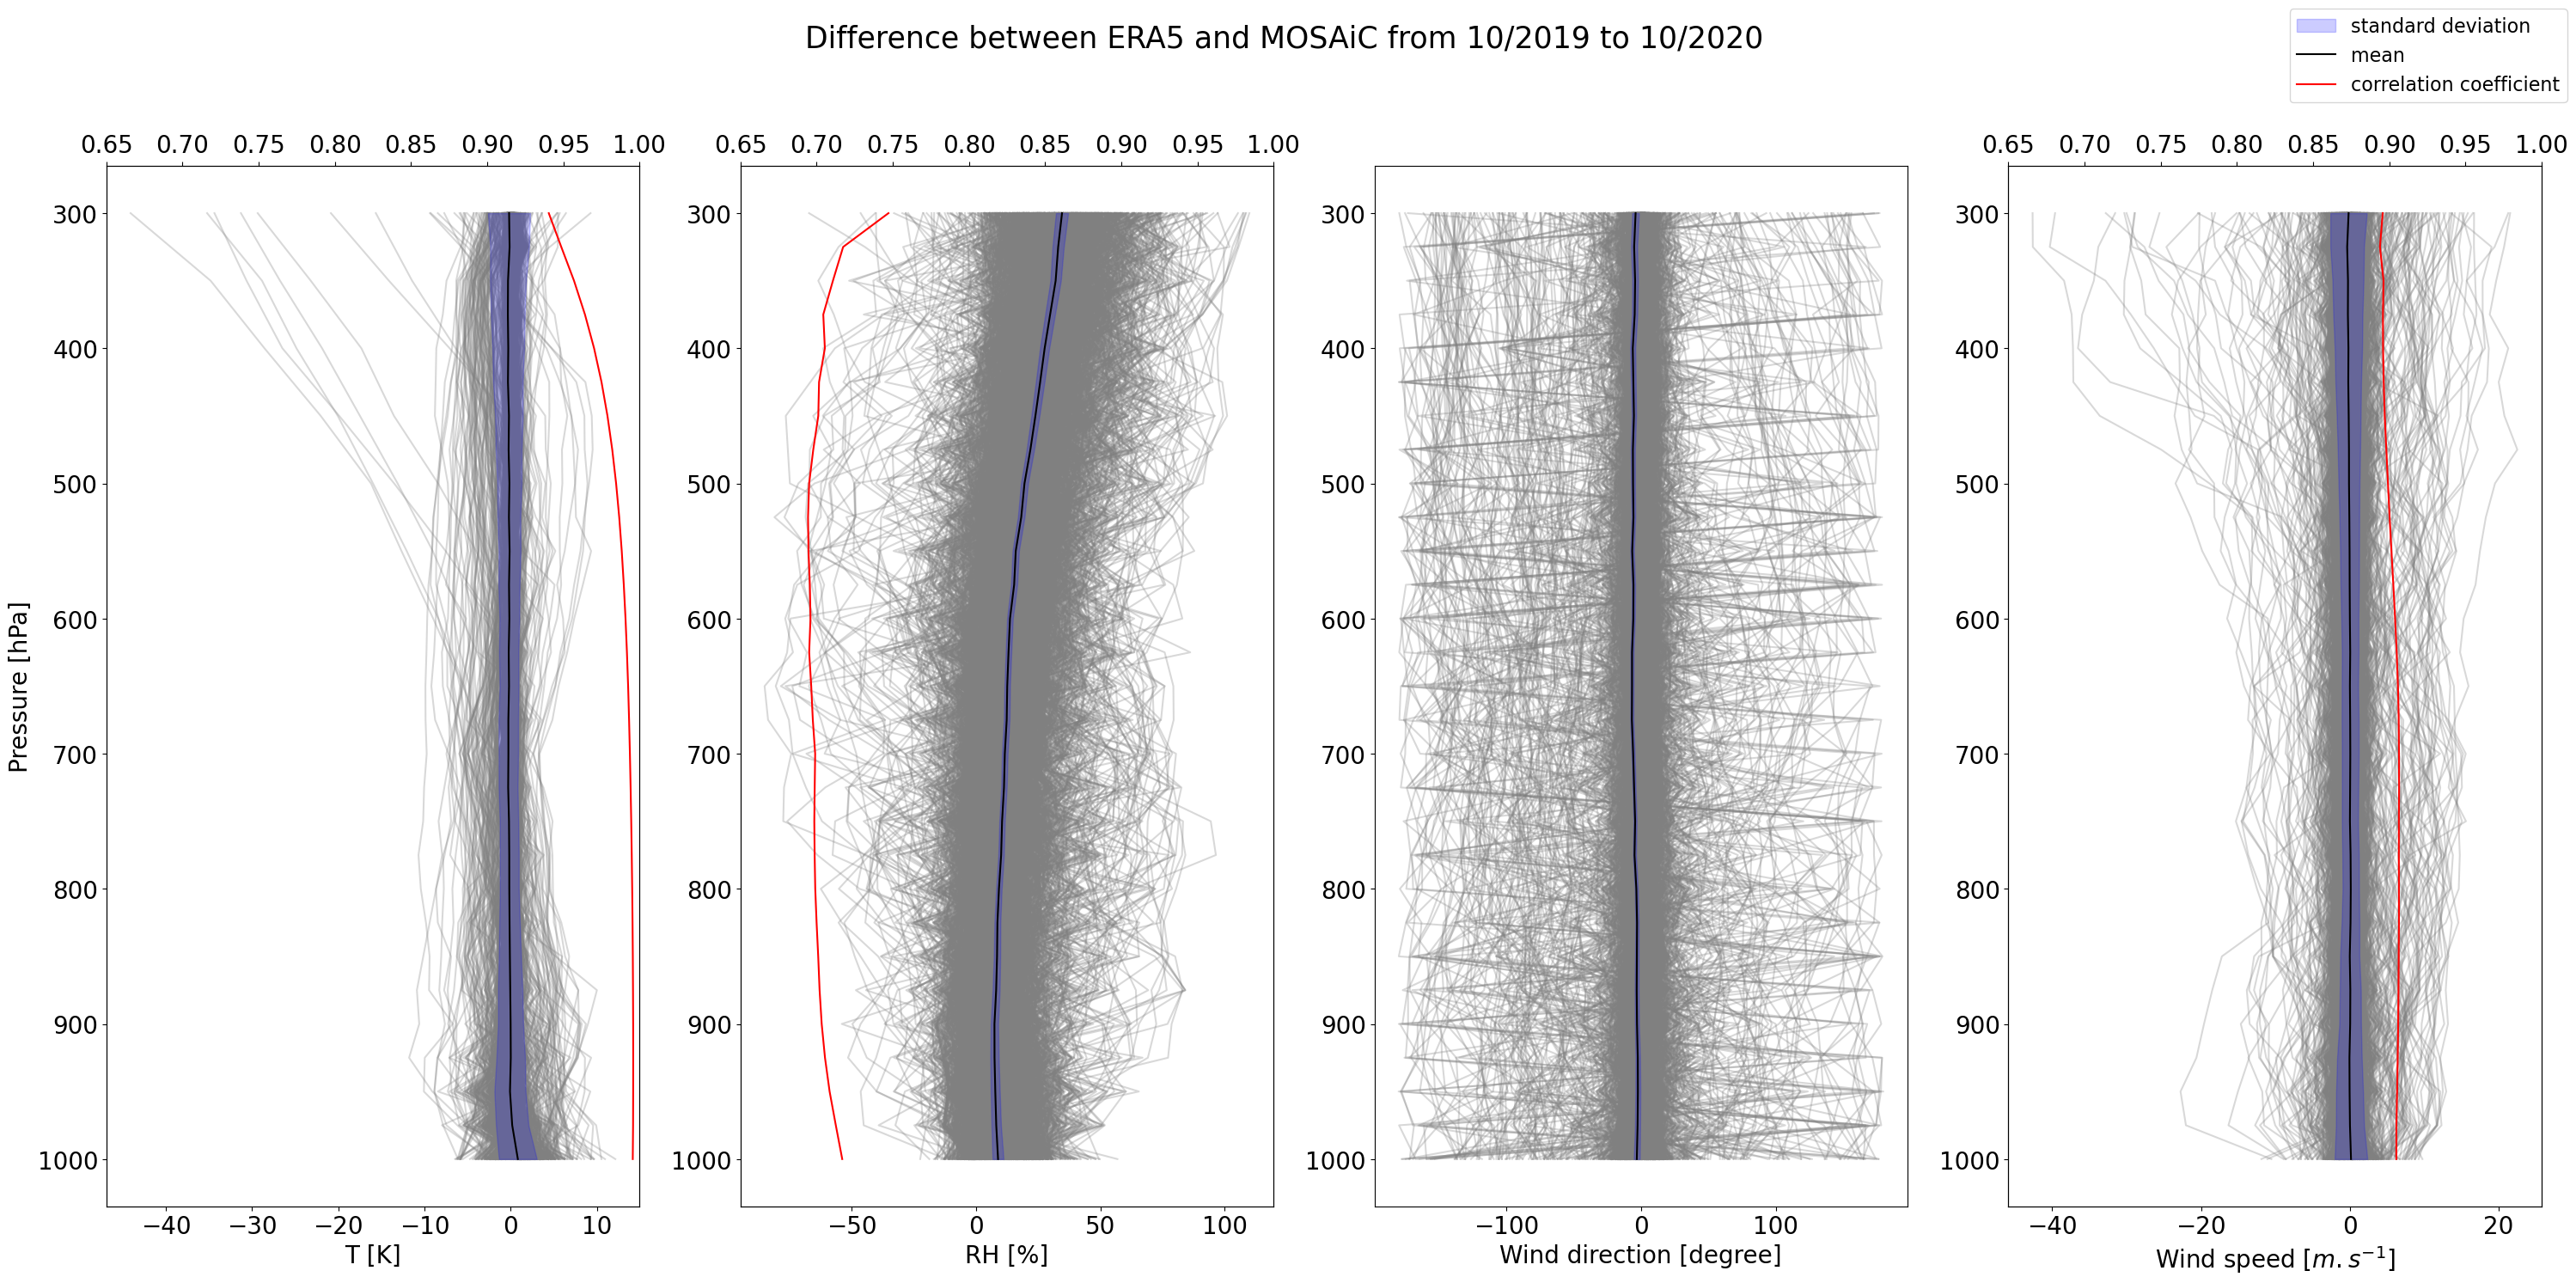

In [271]:
plotbiases() #comment this line to not plot figures
#positive = surestimation in ERA5